In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import PredefinedSplit, GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import GaussianNB, BernoulliNB

In [4]:
train = pd.read_csv('data/GrantApplication/unimelb_training.csv', low_memory=False)
test = pd.read_csv('data/GrantApplication/unimelb_test.csv', low_memory=False)

In [5]:
train.shape, test.shape

((8708, 252), (2176, 252))

In [6]:
train.columns = train.columns.str.replace('.', '_')
test.columns = test.columns.str.replace('.', '_')

In [7]:
train['Grant_Application_ID'] = 'tr' + train['Grant_Application_ID'].astype(str)
test['Grant_Application_ID'] = 'ts' + test['Grant_Application_ID'].astype(str)

In [8]:
traintest = pd.concat([train, test])
traintest.shape

(10884, 252)

In [9]:
traintest['Start_date'] = pd.to_datetime(traintest['Start_date'])
traintest['Start_year'] = traintest['Start_date'].dt.year
traintest['Start_month'] = traintest['Start_date'].dt.month

traintest.drop(['Unnamed: 251', 'Start_date'], axis=1, inplace=True)

In [10]:
train.head()

,Grant_Application_ID,Grant_Status,Sponsor_Code,Grant_Category_Code,Contract_Value_Band___see_note_A,Start_date,RFCD_Code_1,RFCD_Percentage_1,RFCD_Code_2,RFCD_Percentage_2,...,Faculty_No__15,With_PHD_15,No__of_Years_in_Uni_at_Time_of_Grant_15,Number_of_Successful_Grant_15,Number_of_Unsuccessful_Grant_15,A__15,A_15,B_15,C_15,Unnamed: 251
0,tr1,1,NaN,NaN,A,8/11/05,280199.0,100.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tr2,1,2B,10A,B,11/11/05,280103.0,30.0,280106.0,30.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tr3,1,29A,10B,A,14/11/05,321004.0,60.0,321216.0,40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tr4,1,40D,10B,C,15/11/05,270602.0,50.0,320602.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tr5,0,59C,10A,A,16/11/05,260500.0,34.0,280000.0,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
test.head()

,Grant_Application_ID,Grant_Status,Sponsor_Code,Grant_Category_Code,Contract_Value_Band___see_note_A,Start_date,RFCD_Code_1,RFCD_Percentage_1,RFCD_Code_2,RFCD_Percentage_2,...,Faculty_No__15,With_PHD_15,No__of_Years_in_Uni_at_Time_of_Grant_15,Number_of_Successful_Grant_15,Number_of_Unsuccessful_Grant_15,A__15,A_15,B_15,C_15,Unnamed: 251
0,ts1,NaN,47C,10B,A,1/01/09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ts2,NaN,32D,30B,D,1/01/09,270199.0,100.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ts3,NaN,99C,30B,I,1/01/09,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ts4,NaN,2B,10A,E,1/01/09,280204.0,60.0,280506.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ts5,NaN,24D,30B,B,1/01/09,320502.0,50.0,320703.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
traintest.head()

,Grant_Application_ID,Grant_Status,Sponsor_Code,Grant_Category_Code,Contract_Value_Band___see_note_A,RFCD_Code_1,RFCD_Percentage_1,RFCD_Code_2,RFCD_Percentage_2,RFCD_Code_3,...,With_PHD_15,No__of_Years_in_Uni_at_Time_of_Grant_15,Number_of_Successful_Grant_15,Number_of_Unsuccessful_Grant_15,A__15,A_15,B_15,C_15,Start_year,Start_month
0,tr1,1.0,NaN,NaN,A,280199.0,100.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005,8
1,tr2,1.0,2B,10A,B,280103.0,30.0,280106.0,30.0,280203.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005,11
2,tr3,1.0,29A,10B,A,321004.0,60.0,321216.0,40.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005,11
3,tr4,1.0,40D,10B,C,270602.0,50.0,320602.0,50.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005,11
4,tr5,0.0,59C,10A,A,260500.0,34.0,280000.0,33.0,290000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2005,11


In [13]:
traintest.drop(traintest.columns[traintest.columns.str.startswith('Person_ID')], axis=1, inplace=True)
traintest.shape

(10884, 237)

## RFCD featues

In [14]:
rfcd_cols = train.columns[train.columns.str.startswith('RFCD')]

grant_cols = train.columns[:6]

In [15]:
traintest['RFCD_Code_1'].fillna(0, inplace=True)
traintest['RFCD_Percentage_1'].fillna(100, inplace=True)

In [16]:
traintest[['Grant_Application_ID'] + list(rfcd_cols)].replace(0.0, np.nan).head()

,Grant_Application_ID,RFCD_Code_1,RFCD_Percentage_1,RFCD_Code_2,RFCD_Percentage_2,RFCD_Code_3,RFCD_Percentage_3,RFCD_Code_4,RFCD_Percentage_4,RFCD_Code_5,RFCD_Percentage_5
0,tr1,280199.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tr2,280103.0,30.0,280106.0,30.0,280203.0,40.0,NaN,NaN,NaN,NaN
2,tr3,321004.0,60.0,321216.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN
3,tr4,270602.0,50.0,320602.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN
4,tr5,260500.0,34.0,280000.0,33.0,290000.0,33.0,NaN,NaN,NaN,NaN


In [17]:
tmp = pd.concat([traintest[['Grant_Application_ID', 
                            'RFCD_Code_{}'.format(i), 
                            'RFCD_Percentage_{}'.format(i)]].rename(columns={'RFCD_Code_{}'.format(i): 'RFCD_Code',
                                                                            'RFCD_Percentage_{}'.format(i): 'RFCD_pct'}) 
                 for i in range(1, 6)], axis=0)

In [18]:
tmp.shape, #tmp.dropna().shape

((54420, 3),)

In [19]:
tmp['RFCD_Code'] = tmp['RFCD_Code'].fillna(0).astype(int).astype(str)
tmp['RFCD_Code'] = tmp['RFCD_Code'].replace('0', 'Unknown').replace('999999', 'Unknown')

In [20]:
tmp.head()

,Grant_Application_ID,RFCD_Code,RFCD_pct
0,tr1,280199,100.0
1,tr2,280103,30.0
2,tr3,321004,60.0
3,tr4,270602,50.0
4,tr5,260500,34.0


In [21]:
tmp = (tmp.groupby(['Grant_Application_ID', 'RFCD_Code'])['RFCD_pct'].sum() / 100).unstack().fillna(0)
tmp.shape

(10884, 824)

In [22]:
tmp.columns = 'rfcd_'+tmp.columns.astype(str)
tmp.head()

,rfcd_210000,rfcd_230101,rfcd_230102,rfcd_230103,rfcd_230104,rfcd_230105,rfcd_230106,rfcd_230107,rfcd_230111,rfcd_230112,...,rfcd_440114,rfcd_440115,rfcd_440199,rfcd_440202,rfcd_440203,rfcd_440204,rfcd_440205,rfcd_440207,rfcd_440209,rfcd_Unknown
Grant_Application_ID,,,,,,,,,,,,,,,,,,,,,
tr1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tr10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tr100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tr1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tr1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
traintest.shape, tmp.shape

((10884, 237), (10884, 824))

In [24]:
traintest = traintest.merge(tmp, left_on='Grant_Application_ID', right_index=True, how='left')
print(traintest.shape, 'after merge')
del tmp
traintest.drop(rfcd_cols, axis=1, inplace=True)
print(traintest.shape, 'after drop rfcd')

(10884, 1061) after merge
(10884, 1051) after drop rfcd


## SEO features

In [25]:
seo_cols = train.columns[train.columns.str.startswith('SEO')]

traintest[seo_cols] = traintest[seo_cols].replace(0.0, np.nan)

In [26]:
traintest['SEO_Code_1'] = traintest['SEO_Code_1'].fillna(0)

In [27]:
traintest['SEO_Percentage_1'] = traintest['SEO_Percentage_1'].fillna(100)

In [28]:
traintest[seo_cols].head()

,SEO_Code_1,SEO_Percentage_1,SEO_Code_2,SEO_Percentage_2,SEO_Code_3,SEO_Percentage_3,SEO_Code_4,SEO_Percentage_4,SEO_Code_5,SEO_Percentage_5
0,700299.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,700103.0,50.0,700102.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN
2,730105.0,60.0,730207.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN
3,730106.0,70.0,730201.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
4,770199.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
pd.Series(traintest[seo_cols].values.ravel()).value_counts()[:10]

100.0    4957
50.0     3496
30.0     2466
20.0     2453
40.0     2113
10.0     1167
dtype: int64

In [30]:
tmp = pd.concat([traintest[['Grant_Application_ID', 
                            'SEO_Code_{}'.format(i), 
                            'SEO_Percentage_{}'.format(i)]].rename(columns={'SEO_Code_{}'.format(i): "SEO_Code",
                                                                           'SEO_Percentage_{}'.format(i):'SEO_Percentage'}) 
                 for i in range(1, 6)], axis=0)

In [31]:
tmp.dropna(inplace=True)

In [32]:
tmp['SEO_Code'] = tmp['SEO_Code'].astype(int).astype(str).replace('0', 'Unknown').replace('999999', 'Unknown')

In [33]:
tmp = tmp.groupby(['Grant_Application_ID', 'SEO_Code'])['SEO_Percentage'].sum().unstack().fillna(0) / 100

In [34]:
tmp.columns = 'SEO_' + tmp.columns.astype(str)

In [35]:
tmp.head()

,SEO_610101,SEO_610102,SEO_610103,SEO_610104,SEO_610199,SEO_620000,SEO_620101,SEO_620102,SEO_620103,SEO_620104,...,SEO_780101,SEO_780102,SEO_780103,SEO_780104,SEO_780105,SEO_780106,SEO_780107,SEO_780108,SEO_780199,SEO_Unknown
Grant_Application_ID,,,,,,,,,,,,,,,,,,,,,
tr1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tr10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tr100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0
tr1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tr1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
traintest = traintest.merge(tmp, left_on='Grant_Application_ID', right_index=True, how='left')
traintest.shape

(10884, 1562)

In [37]:
traintest.drop(seo_cols, axis=1, inplace=True)
del tmp

In [38]:
traintest.head()

,Grant_Application_ID,Grant_Status,Sponsor_Code,Grant_Category_Code,Contract_Value_Band___see_note_A,Role_1,Year_of_Birth_1,Country_of_Birth_1,Home_Language_1,Dept_No__1,...,SEO_780101,SEO_780102,SEO_780103,SEO_780104,SEO_780105,SEO_780106,SEO_780107,SEO_780108,SEO_780199,SEO_Unknown
0,tr1,1.0,NaN,NaN,A,CHIEF_INVESTIGATOR,1965.0,Asia Pacific,Other,3073.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tr2,1.0,2B,10A,B,CHIEF_INVESTIGATOR,1960.0,Australia,NaN,2538.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tr3,1.0,29A,10B,A,CHIEF_INVESTIGATOR,1955.0,Australia,NaN,2923.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tr4,1.0,40D,10B,C,PRINCIPAL_SUPERVISOR,1955.0,Australia,NaN,2678.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tr5,0.0,59C,10A,A,CHIEF_INVESTIGATOR,1965.0,Western Europe,NaN,2153.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Role_[1-15]
* num_candidates for each grant
* num_[Role..] for each grant

In [39]:
role_cols = train.columns[train.columns.str.startswith('Role_')]

In [40]:
train[role_cols].head()

,Role_1,Role_2,Role_3,Role_4,Role_5,Role_6,Role_7,Role_8,Role_9,Role_10,Role_11,Role_12,Role_13,Role_14,Role_15
0,CHIEF_INVESTIGATOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CHIEF_INVESTIGATOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CHIEF_INVESTIGATOR,CHIEF_INVESTIGATOR,CHIEF_INVESTIGATOR,DELEGATED_RESEARCHER,EXT_CHIEF_INVESTIGATOR,EXT_CHIEF_INVESTIGATOR,EXT_CHIEF_INVESTIGATOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,PRINCIPAL_SUPERVISOR,CHIEF_INVESTIGATOR,EXT_CHIEF_INVESTIGATOR,EXT_CHIEF_INVESTIGATOR,EXT_CHIEF_INVESTIGATOR,STUD_CHIEF_INVESTIGATOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CHIEF_INVESTIGATOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
traintest['Role_1'] = traintest['Role_1'].fillna('Unknown')

In [42]:
traintest['Role_1'].value_counts(dropna=False)

CHIEF_INVESTIGATOR         9630
EXT_CHIEF_INVESTIGATOR      544
PRINCIPAL_SUPERVISOR        425
DELEGATED_RESEARCHER        121
Unknown                     118
STUD_CHIEF_INVESTIGATOR      29
HONVISIT                     15
EXTERNAL_ADVISOR              2
Name: Role_1, dtype: int64

In [43]:
tmp = pd.concat([traintest[['Grant_Application_ID', 
                            'Role_{}'.format(i)]].rename(columns={'Role_{}'.format(i): 'Role'}) 
                 for i in range(1, 16)]).dropna()

tmp['n'] = 1

In [44]:
tmp = tmp.groupby(['Grant_Application_ID', 'Role'])['n'].sum().unstack().fillna(0).astype(int)

In [45]:
tmp.columns = 'Num_' + tmp.columns.astype(str)

In [46]:
traintest = traintest.merge(tmp, left_on='Grant_Application_ID', right_index=True, how='left')
traintest['Num_Total'] = traintest.iloc[:, -9:].sum(axis=1)
del tmp

In [47]:
traintest.iloc[:, -9:].sum(axis=1).describe()

count    10884.000000
mean         2.763047
std          2.366997
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         24.000000
dtype: float64

In [48]:

traintest.iloc[:, -10:].head()

,Num_CHIEF_INVESTIGATOR,Num_DELEGATED_RESEARCHER,Num_EXTERNAL_ADVISOR,Num_EXT_CHIEF_INVESTIGATOR,Num_HONVISIT,Num_PRINCIPAL_SUPERVISOR,Num_STUDRES,Num_STUD_CHIEF_INVESTIGATOR,Num_Unknown,Num_Total
0,1,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,1
2,3,1,0,3,0,0,0,0,0,7
3,1,0,0,3,0,1,0,1,0,6
4,1,0,0,0,0,0,0,0,0,1


## Role - Home_language: combine
* RL_...

In [49]:
lang_cols = traintest.columns[traintest.columns.str.startswith('Home_Lan')]
lang_cols

Index(['Home_Language_1', 'Home_Language_2', 'Home_Language_3',
       'Home_Language_4', 'Home_Language_5', 'Home_Language_6',
       'Home_Language_7', 'Home_Language_8', 'Home_Language_9',
       'Home_Language_10', 'Home_Language_11', 'Home_Language_12',
       'Home_Language_13', 'Home_Language_14', 'Home_Language_15'],
      dtype='object')

In [50]:
train[lang_cols].head()

,Home_Language_1,Home_Language_2,Home_Language_3,Home_Language_4,Home_Language_5,Home_Language_6,Home_Language_7,Home_Language_8,Home_Language_9,Home_Language_10,Home_Language_11,Home_Language_12,Home_Language_13,Home_Language_14,Home_Language_15
0,Other,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
tmp = pd.concat([traintest[['Grant_Application_ID', 
                         'Role_{}'.format(i), 
                         'Home_Language_{}'.format(i)]].rename(columns={'Role_{}'.format(i): 'Role',
                                                                        'Home_Language_{}'.format(i): 'Home_Language'}) 
               for i in range(1, 15)], axis=0)

In [52]:
tmp = tmp.loc[tmp.Role.notnull(), :]

In [53]:
tmp['Home_Language'] = tmp['Home_Language'].fillna('Unknown')

In [54]:
tmp['Role_Lang'] = tmp['Role'] + '_Lan_' + tmp['Home_Language']

In [55]:
tmp = tmp.groupby(['Grant_Application_ID', 'Role_Lang'])['Role'].count().unstack().fillna(0).astype(int)

In [56]:
traintest = traintest.merge(tmp, left_on='Grant_Application_ID', right_index=True, how='left')
del tmp
traintest.drop(lang_cols, axis=1, inplace=True)
traintest.shape

(10884, 1562)

In [57]:
traintest.iloc[:, -15:].head()

,CHIEF_INVESTIGATOR_Lan_English,CHIEF_INVESTIGATOR_Lan_Other,CHIEF_INVESTIGATOR_Lan_Unknown,DELEGATED_RESEARCHER_Lan_English,DELEGATED_RESEARCHER_Lan_Other,DELEGATED_RESEARCHER_Lan_Unknown,EXTERNAL_ADVISOR_Lan_Unknown,EXT_CHIEF_INVESTIGATOR_Lan_English,EXT_CHIEF_INVESTIGATOR_Lan_Unknown,HONVISIT_Lan_Unknown,PRINCIPAL_SUPERVISOR_Lan_English,PRINCIPAL_SUPERVISOR_Lan_Unknown,STUDRES_Lan_Unknown,STUD_CHIEF_INVESTIGATOR_Lan_Unknown,Unknown_Lan_Unknown
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,3,0,0,1,0,0,3,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,3,0,0,1,0,1,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


## Role - Year_of_Birth
* RY_...

In [58]:
yob = traintest.columns[traintest.columns.str.startswith('Year_of_Birth')]

In [59]:
traintest[yob].describe().T

,count,mean,std,min,25%,50%,75%,max
Year_of_Birth_1,10186.0,1962.618790,9.461021,1925.0,1955.00,1965.0,1970.00,1985.0
Year_of_Birth_2,3879.0,1960.608404,10.158798,1900.0,1955.00,1960.0,1970.00,1985.0
Year_of_Birth_3,1565.0,1959.456869,10.938632,1900.0,1950.00,1960.0,1965.00,1985.0
Year_of_Birth_4,601.0,1958.402662,9.888255,1925.0,1950.00,1960.0,1965.00,1985.0
Year_of_Birth_5,223.0,1957.959641,9.140208,1930.0,1950.00,1960.0,1965.00,1980.0
Year_of_Birth_6,95.0,1959.210526,10.874423,1935.0,1950.00,1960.0,1965.00,1980.0
Year_of_Birth_7,57.0,1959.473684,9.621600,1945.0,1950.00,1960.0,1970.00,1975.0
Year_of_Birth_8,17.0,1958.235294,9.344313,1945.0,1950.00,1955.0,1965.00,1975.0
Year_of_Birth_9,13.0,1962.692308,9.919548,1950.0,1955.00,1965.0,1970.00,1975.0
Year_of_Birth_10,10.0,1957.000000,10.593499,1940.0,1950.00,1957.5,1965.00,1970.0


In [60]:
tmp =  pd.concat([traintest[['Grant_Application_ID', 
                          'Role_{}'.format(i), 
                          'Year_of_Birth_{}'.format(i)]].rename(columns={'Role_{}'.format(i): 'Role',
                                                                        'Year_of_Birth_{}'.format(i): 'YoB'}) 
               for i in range(1, 16)], axis=0)

In [61]:
tmp = tmp.loc[tmp['Role'].notnull(), :]

In [62]:
tmp['YoB'] = (tmp['YoB'] //10 * 10).fillna(0).astype(int).astype(str).replace('0', 'Unk_yr')

In [63]:
tmp['Role_Yr'] = tmp['Role'] + '_' + tmp['YoB']

In [64]:
tmp = tmp.groupby(['Grant_Application_ID', 'Role_Yr'])['Role'].count().unstack().fillna(0).astype(int)

In [65]:
tmp.head()

Role_Yr,CHIEF_INVESTIGATOR_1900,CHIEF_INVESTIGATOR_1920,CHIEF_INVESTIGATOR_1930,CHIEF_INVESTIGATOR_1940,CHIEF_INVESTIGATOR_1950,CHIEF_INVESTIGATOR_1960,CHIEF_INVESTIGATOR_1970,CHIEF_INVESTIGATOR_1980,CHIEF_INVESTIGATOR_Unk_yr,DELEGATED_RESEARCHER_1940,...,HONVISIT_1980,PRINCIPAL_SUPERVISOR_1940,PRINCIPAL_SUPERVISOR_1950,PRINCIPAL_SUPERVISOR_1960,PRINCIPAL_SUPERVISOR_1970,PRINCIPAL_SUPERVISOR_1980,STUDRES_1970,STUDRES_Unk_yr,STUD_CHIEF_INVESTIGATOR_Unk_yr,Unknown_Unk_yr
Grant_Application_ID,,,,,,,,,,,,,,,,,,,,,
tr1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tr10,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tr100,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tr1000,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tr1001,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
traintest = traintest.merge(tmp, left_on='Grant_Application_ID', right_index=True, how='left')
del tmp
#traintest.drop(yob, axis=1, inplace=True)
traintest.shape

(10884, 1596)

In [67]:
traintest.iloc[:, -34:].head()

,CHIEF_INVESTIGATOR_1900,CHIEF_INVESTIGATOR_1920,CHIEF_INVESTIGATOR_1930,CHIEF_INVESTIGATOR_1940,CHIEF_INVESTIGATOR_1950,CHIEF_INVESTIGATOR_1960,CHIEF_INVESTIGATOR_1970,CHIEF_INVESTIGATOR_1980,CHIEF_INVESTIGATOR_Unk_yr,DELEGATED_RESEARCHER_1940,...,HONVISIT_1980,PRINCIPAL_SUPERVISOR_1940,PRINCIPAL_SUPERVISOR_1950,PRINCIPAL_SUPERVISOR_1960,PRINCIPAL_SUPERVISOR_1970,PRINCIPAL_SUPERVISOR_1980,STUDRES_1970,STUDRES_Unk_yr,STUD_CHIEF_INVESTIGATOR_Unk_yr,Unknown_Unk_yr
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Candidate Age

In [68]:
tmp = pd.concat([traintest[['Grant_Application_ID', 'Start_year',
                            'Role_{}'.format(i), 
                            'Year_of_Birth_{}'.format(i)]].rename(columns={'Role_{}'.format(i):'Role',
                                                                          'Year_of_Birth_{}'.format(i):'YoB'}) 
                 for i in range(1, 16)])

In [69]:
tmp = tmp.loc[tmp['Role'].notnull(), :]
#tmp.dropna(inplace=True)
tmp.shape

(22802, 4)

In [70]:
tmp['Age'] = tmp['Start_year'] - tmp['YoB']
tmp['Age'].isnull().sum()

6133

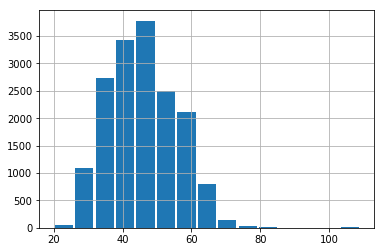

In [71]:
tmp['Age'].hist(rwidth=.9, bins=15)

In [72]:
age_by_grant_id = tmp.groupby('Grant_Application_ID')['Age'].mean().fillna(-1)
age_by_grant_id.shape

(10884,)

In [73]:
tmp = (tmp.groupby(['Grant_Application_ID', 'Role'])['Age'].mean() // 5 * 5).fillna(0)
tmp = tmp.astype(int).astype(str).replace('0', 'Unk').reset_index()

In [74]:
tmp.loc[tmp['Age'] == '105', 'Age'] = 'Unk'

In [75]:
tmp['Role_Age'] = tmp['Role'] + '_age_' + tmp['Age']

In [76]:
tmp.head()

,Grant_Application_ID,Role,Age,Role_Age
0,tr1,CHIEF_INVESTIGATOR,40,CHIEF_INVESTIGATOR_age_40
1,tr10,CHIEF_INVESTIGATOR,75,CHIEF_INVESTIGATOR_age_75
2,tr10,EXT_CHIEF_INVESTIGATOR,Unk,EXT_CHIEF_INVESTIGATOR_age_Unk
3,tr100,CHIEF_INVESTIGATOR,60,CHIEF_INVESTIGATOR_age_60
4,tr1000,CHIEF_INVESTIGATOR,40,CHIEF_INVESTIGATOR_age_40


In [77]:
tmp = tmp.groupby(['Grant_Application_ID', 'Role_Age'])['Role'].count().unstack().fillna(0).astype(int)

In [78]:
tmp.head()

Role_Age,CHIEF_INVESTIGATOR_age_20,CHIEF_INVESTIGATOR_age_25,CHIEF_INVESTIGATOR_age_30,CHIEF_INVESTIGATOR_age_35,CHIEF_INVESTIGATOR_age_40,CHIEF_INVESTIGATOR_age_45,CHIEF_INVESTIGATOR_age_50,CHIEF_INVESTIGATOR_age_55,CHIEF_INVESTIGATOR_age_60,CHIEF_INVESTIGATOR_age_65,...,PRINCIPAL_SUPERVISOR_age_35,PRINCIPAL_SUPERVISOR_age_40,PRINCIPAL_SUPERVISOR_age_45,PRINCIPAL_SUPERVISOR_age_50,PRINCIPAL_SUPERVISOR_age_55,PRINCIPAL_SUPERVISOR_age_60,STUDRES_age_30,STUDRES_age_Unk,STUD_CHIEF_INVESTIGATOR_age_Unk,Unknown_age_Unk
Grant_Application_ID,,,,,,,,,,,,,,,,,,,,,
tr1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tr10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tr100,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
tr1000,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tr1001,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [79]:
traintest = traintest.merge(tmp, left_on='Grant_Application_ID', right_index=True, how='left')
traintest['avg_candidate_age'] = traintest['Grant_Application_ID'].map(age_by_grant_id)
del tmp

In [80]:
traintest.iloc[:, -54:].head()

,CHIEF_INVESTIGATOR_age_20,CHIEF_INVESTIGATOR_age_25,CHIEF_INVESTIGATOR_age_30,CHIEF_INVESTIGATOR_age_35,CHIEF_INVESTIGATOR_age_40,CHIEF_INVESTIGATOR_age_45,CHIEF_INVESTIGATOR_age_50,CHIEF_INVESTIGATOR_age_55,CHIEF_INVESTIGATOR_age_60,CHIEF_INVESTIGATOR_age_65,...,PRINCIPAL_SUPERVISOR_age_40,PRINCIPAL_SUPERVISOR_age_45,PRINCIPAL_SUPERVISOR_age_50,PRINCIPAL_SUPERVISOR_age_55,PRINCIPAL_SUPERVISOR_age_60,STUDRES_age_30,STUDRES_age_Unk,STUD_CHIEF_INVESTIGATOR_age_Unk,Unknown_age_Unk,avg_candidate_age
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,40.00
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,45.00
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,53.75
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,40.00
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,40.00


In [81]:
del seo_cols
traintest.shape

(10884, 1650)

In [82]:
traintest.drop(yob, axis=1, inplace=True)
traintest.shape

(10884, 1635)

## Role - Country_of_Birth

In [83]:
cob = traintest.columns[traintest.columns.str.startswith('Country_of_Birth')]

In [84]:
traintest[cob].head()

,Country_of_Birth_1,Country_of_Birth_2,Country_of_Birth_3,Country_of_Birth_4,Country_of_Birth_5,Country_of_Birth_6,Country_of_Birth_7,Country_of_Birth_8,Country_of_Birth_9,Country_of_Birth_10,Country_of_Birth_11,Country_of_Birth_12,Country_of_Birth_13,Country_of_Birth_14,Country_of_Birth_15
0,Asia Pacific,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Australia,Australia,Asia Pacific,Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Australia,Australia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Western Europe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
tmp = pd.concat([traintest[['Grant_Application_ID', 
                            'Role_{}'.format(i), 
                            'Country_of_Birth_{}'.format(i)]].rename(columns={'Role_{}'.format(i):'Role',
                                                                             'Country_of_Birth_{}'.format(i):'CoB'}) 
                 for i in range(1, 16)])

In [86]:
tmp = tmp.loc[tmp['Role'].notnull(), :]

In [87]:
tmp['CoB'] = tmp['CoB'].fillna('Unknown')

In [88]:
tmp['CoB'].value_counts(dropna=False)

Australia                 10821
Unknown                    8153
Great Britain              1241
Asia Pacific                765
Western Europe              608
North America               440
Eastern Europe              244
New Zealand                 161
Middle East and Africa      133
The Americas                120
South Africa                116
Name: CoB, dtype: int64

In [89]:
tmp['Role_CoB'] = tmp['Role'] + '_born_' + tmp['CoB']

In [90]:
tmp = tmp.groupby(['Grant_Application_ID', 'Role_CoB'])['Role'].count().unstack().fillna(0).astype(int)

In [91]:
tmp.head()

Role_CoB,CHIEF_INVESTIGATOR_born_Asia Pacific,CHIEF_INVESTIGATOR_born_Australia,CHIEF_INVESTIGATOR_born_Eastern Europe,CHIEF_INVESTIGATOR_born_Great Britain,CHIEF_INVESTIGATOR_born_Middle East and Africa,CHIEF_INVESTIGATOR_born_New Zealand,CHIEF_INVESTIGATOR_born_North America,CHIEF_INVESTIGATOR_born_South Africa,CHIEF_INVESTIGATOR_born_The Americas,CHIEF_INVESTIGATOR_born_Unknown,...,PRINCIPAL_SUPERVISOR_born_Asia Pacific,PRINCIPAL_SUPERVISOR_born_Australia,PRINCIPAL_SUPERVISOR_born_Great Britain,PRINCIPAL_SUPERVISOR_born_New Zealand,PRINCIPAL_SUPERVISOR_born_South Africa,PRINCIPAL_SUPERVISOR_born_The Americas,PRINCIPAL_SUPERVISOR_born_Unknown,STUDRES_born_Unknown,STUD_CHIEF_INVESTIGATOR_born_Unknown,Unknown_born_Unknown
Grant_Application_ID,,,,,,,,,,,,,,,,,,,,,
tr1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tr10,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
tr100,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tr1000,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tr1001,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
traintest = traintest.merge(tmp, left_on=['Grant_Application_ID'], right_index=True, how='left')
del tmp
print(traintest.shape)
traintest.drop(cob, axis=1, inplace=True)
del cob
print(traintest.shape)


(10884, 1668)
(10884, 1653)


In [93]:
traintest.iloc[:, -33:].head()

,CHIEF_INVESTIGATOR_born_Asia Pacific,CHIEF_INVESTIGATOR_born_Australia,CHIEF_INVESTIGATOR_born_Eastern Europe,CHIEF_INVESTIGATOR_born_Great Britain,CHIEF_INVESTIGATOR_born_Middle East and Africa,CHIEF_INVESTIGATOR_born_New Zealand,CHIEF_INVESTIGATOR_born_North America,CHIEF_INVESTIGATOR_born_South Africa,CHIEF_INVESTIGATOR_born_The Americas,CHIEF_INVESTIGATOR_born_Unknown,...,PRINCIPAL_SUPERVISOR_born_Asia Pacific,PRINCIPAL_SUPERVISOR_born_Australia,PRINCIPAL_SUPERVISOR_born_Great Britain,PRINCIPAL_SUPERVISOR_born_New Zealand,PRINCIPAL_SUPERVISOR_born_South Africa,PRINCIPAL_SUPERVISOR_born_The Americas,PRINCIPAL_SUPERVISOR_born_Unknown,STUDRES_born_Unknown,STUD_CHIEF_INVESTIGATOR_born_Unknown,Unknown_born_Unknown
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Role - Dept.No.

In [94]:
dept_cols = traintest.columns[traintest.columns.str.startswith('Dept_No')]

In [95]:
traintest[dept_cols].head()

,Dept_No__1,Dept_No__2,Dept_No__3,Dept_No__4,Dept_No__5,Dept_No__6,Dept_No__7,Dept_No__8,Dept_No__9,Dept_No__10,Dept_No__11,Dept_No__12,Dept_No__13,Dept_No__14,Dept_No__15
0,3073.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2538.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2923.0,2923.0,2498.0,2548.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2678.0,2678.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2153.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [96]:
tmp = pd.concat([traintest[['Grant_Application_ID', 
                            'Role_{}'.format(i), 
                            'Dept_No__{}'.format(i)]].rename(columns={'Role_{}'.format(i): 'Role',
                                                                     'Dept_No__{}'.format(i):'Dept_No'}) 
                 for i in range(1, 16)])

In [97]:
tmp = tmp.loc[tmp['Role'].notnull(), :]

In [98]:
tmp['Dept_No'] = tmp['Dept_No'].fillna(0).astype(int).astype(str).replace('0', 'Unknown')

In [99]:
tmp['Role_Dept'] = tmp['Role'] + '_dept_' + tmp['Dept_No']

In [100]:
tmp = tmp.groupby(['Grant_Application_ID', 'Role_Dept'])['Role'].count().unstack().fillna(0).astype(int)

In [101]:
tmp.head()

Role_Dept,CHIEF_INVESTIGATOR_dept_1013,CHIEF_INVESTIGATOR_dept_1033,CHIEF_INVESTIGATOR_dept_1038,CHIEF_INVESTIGATOR_dept_1098,CHIEF_INVESTIGATOR_dept_118,CHIEF_INVESTIGATOR_dept_1253,CHIEF_INVESTIGATOR_dept_1258,CHIEF_INVESTIGATOR_dept_1428,CHIEF_INVESTIGATOR_dept_148,CHIEF_INVESTIGATOR_dept_1498,...,PRINCIPAL_SUPERVISOR_dept_3028,PRINCIPAL_SUPERVISOR_dept_3258,PRINCIPAL_SUPERVISOR_dept_3268,PRINCIPAL_SUPERVISOR_dept_4323,PRINCIPAL_SUPERVISOR_dept_653,PRINCIPAL_SUPERVISOR_dept_Unknown,STUDRES_dept_3048,STUDRES_dept_Unknown,STUD_CHIEF_INVESTIGATOR_dept_Unknown,Unknown_dept_Unknown
Grant_Application_ID,,,,,,,,,,,,,,,,,,,,,
tr1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tr10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tr100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tr1000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
tr1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [102]:
traintest = traintest.merge(tmp, left_on='Grant_Application_ID', right_index=True, how='left')
del tmp
print(traintest.shape)
traintest.drop(dept_cols, axis=1, inplace=True)
del dept_cols
print(traintest.shape)

(10884, 1856)
(10884, 1841)


In [103]:
traintest.iloc[:, -207:].head()

,PRINCIPAL_SUPERVISOR_born_Unknown,STUDRES_born_Unknown,STUD_CHIEF_INVESTIGATOR_born_Unknown,Unknown_born_Unknown,CHIEF_INVESTIGATOR_dept_1013,CHIEF_INVESTIGATOR_dept_1033,CHIEF_INVESTIGATOR_dept_1038,CHIEF_INVESTIGATOR_dept_1098,CHIEF_INVESTIGATOR_dept_118,CHIEF_INVESTIGATOR_dept_1253,...,PRINCIPAL_SUPERVISOR_dept_3028,PRINCIPAL_SUPERVISOR_dept_3258,PRINCIPAL_SUPERVISOR_dept_3268,PRINCIPAL_SUPERVISOR_dept_4323,PRINCIPAL_SUPERVISOR_dept_653,PRINCIPAL_SUPERVISOR_dept_Unknown,STUDRES_dept_3048,STUDRES_dept_Unknown,STUD_CHIEF_INVESTIGATOR_dept_Unknown,Unknown_dept_Unknown
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Role - Faculty.No.

In [104]:
fac_cols = traintest.columns[traintest.columns.str.startswith('Faculty_No__')]
fac_cols

Index(['Faculty_No__1', 'Faculty_No__2', 'Faculty_No__3', 'Faculty_No__4',
       'Faculty_No__5', 'Faculty_No__6', 'Faculty_No__7', 'Faculty_No__8',
       'Faculty_No__9', 'Faculty_No__10', 'Faculty_No__11', 'Faculty_No__12',
       'Faculty_No__13', 'Faculty_No__14', 'Faculty_No__15'],
      dtype='object')

In [105]:
traintest[fac_cols].head()

,Faculty_No__1,Faculty_No__2,Faculty_No__3,Faculty_No__4,Faculty_No__5,Faculty_No__6,Faculty_No__7,Faculty_No__8,Faculty_No__9,Faculty_No__10,Faculty_No__11,Faculty_No__12,Faculty_No__13,Faculty_No__14,Faculty_No__15
0,31.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25.0,25.0,25.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
tmp = pd.concat([traintest[['Grant_Application_ID', 
                            'Role_{}'.format(i), 
                            'Faculty_No__{}'.format(i)]].rename(columns={'Role_{}'.format(i):'Role',
                                                                        'Faculty_No__{}'.format(i):'Faculty_No'}) 
                 for i in range(1, 16)], axis=0)

In [107]:
tmp = tmp.loc[tmp['Role'].notnull(), :]

In [108]:
tmp['Faculty_No'] = tmp['Faculty_No'].fillna(0).astype(int).astype(str).replace('0', 'Unknown')

In [109]:
tmp['Role_Fac'] = tmp['Role'] + '_fac_' + tmp['Faculty_No']

In [110]:
tmp = tmp.groupby(['Grant_Application_ID', 'Role_Fac']).size().unstack().fillna(0).astype(int)

In [111]:
traintest = traintest.merge(tmp, left_on='Grant_Application_ID', right_index=True, how='left')
del tmp
print(traintest.shape)
traintest.drop(fac_cols, axis=1, inplace=True)
print(traintest.shape)
del fac_cols

(10884, 1891)
(10884, 1876)


In [112]:
traintest.iloc[:, -50:].head()

,CHIEF_INVESTIGATOR_fac_1,CHIEF_INVESTIGATOR_fac_10,CHIEF_INVESTIGATOR_fac_118,CHIEF_INVESTIGATOR_fac_13,CHIEF_INVESTIGATOR_fac_187,CHIEF_INVESTIGATOR_fac_19,CHIEF_INVESTIGATOR_fac_22,CHIEF_INVESTIGATOR_fac_25,CHIEF_INVESTIGATOR_fac_31,CHIEF_INVESTIGATOR_fac_34,...,PRINCIPAL_SUPERVISOR_fac_1,PRINCIPAL_SUPERVISOR_fac_25,PRINCIPAL_SUPERVISOR_fac_31,PRINCIPAL_SUPERVISOR_fac_34,PRINCIPAL_SUPERVISOR_fac_7,PRINCIPAL_SUPERVISOR_fac_Unknown,STUDRES_fac_31,STUDRES_fac_Unknown,STUD_CHIEF_INVESTIGATOR_fac_Unknown,Unknown_fac_Unknown
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Role - With.PHD.

In [113]:
phd_cols = traintest.columns[traintest.columns.str.startswith('With_PHD_')]
traintest[phd_cols].head()

,With_PHD_1,With_PHD_2,With_PHD_3,With_PHD_4,With_PHD_5,With_PHD_6,With_PHD_7,With_PHD_8,With_PHD_9,With_PHD_10,With_PHD_11,With_PHD_12,With_PHD_13,With_PHD_14,With_PHD_15
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Yes,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [114]:
tmp = pd.concat([traintest[['Grant_Application_ID', 
                            'Role_{}'.format(i), 
                            'With_PHD_{}'.format(i)]].rename(columns={'Role_{}'.format(i):'Role',
                                                                     'With_PHD_{}'.format(i):'PHD'}) 
                 for i in range(1, 16)])

In [115]:
tmp = tmp.loc[tmp['Role'].notnull(), :]

In [116]:
tmp['PHD'] = tmp['PHD'].fillna('No')

In [117]:
tmp['Role_PHD'] = tmp['Role'] + '_PHD_' + tmp['PHD']

In [118]:
tmp = tmp.groupby(['Grant_Application_ID', 'Role_PHD']).size().unstack().fillna(0).astype(int)

In [119]:
tmp.head()

Role_PHD,CHIEF_INVESTIGATOR_PHD_No,CHIEF_INVESTIGATOR_PHD_Yes,DELEGATED_RESEARCHER_PHD_No,DELEGATED_RESEARCHER_PHD_Yes,EXTERNAL_ADVISOR_PHD_No,EXT_CHIEF_INVESTIGATOR_PHD_No,EXT_CHIEF_INVESTIGATOR_PHD_Yes,HONVISIT_PHD_No,HONVISIT_PHD_Yes,PRINCIPAL_SUPERVISOR_PHD_No,PRINCIPAL_SUPERVISOR_PHD_Yes,STUDRES_PHD_No,STUDRES_PHD_Yes,STUD_CHIEF_INVESTIGATOR_PHD_No,Unknown_PHD_No
Grant_Application_ID,,,,,,,,,,,,,,,
tr1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tr10,1,0,0,0,0,3,0,0,0,0,0,0,0,0,0
tr100,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
tr1000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
tr1001,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [120]:
traintest = traintest.merge(tmp, left_on='Grant_Application_ID', right_index=True, how='left')
del tmp
print(traintest.shape)
traintest.drop(phd_cols, axis=1, inplace=True)
del phd_cols
print(traintest.shape)

(10884, 1891)
(10884, 1876)


In [121]:
traintest.iloc[:, -15:].head()

,CHIEF_INVESTIGATOR_PHD_No,CHIEF_INVESTIGATOR_PHD_Yes,DELEGATED_RESEARCHER_PHD_No,DELEGATED_RESEARCHER_PHD_Yes,EXTERNAL_ADVISOR_PHD_No,EXT_CHIEF_INVESTIGATOR_PHD_No,EXT_CHIEF_INVESTIGATOR_PHD_Yes,HONVISIT_PHD_No,HONVISIT_PHD_Yes,PRINCIPAL_SUPERVISOR_PHD_No,PRINCIPAL_SUPERVISOR_PHD_Yes,STUDRES_PHD_No,STUDRES_PHD_Yes,STUD_CHIEF_INVESTIGATOR_PHD_No,Unknown_PHD_No
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2,1,0,0,3,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,3,0,0,0,0,1,0,0,1,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


## Role - No.of.Years.in.Uni.at.Time.of.Grant

In [122]:
n_yr_uni = traintest.columns[traintest.columns.str.startswith('No__of_Years_in_Uni_at_Time_of_Grant')]

In [123]:
traintest[n_yr_uni].head()

,No__of_Years_in_Uni_at_Time_of_Grant_1,No__of_Years_in_Uni_at_Time_of_Grant_2,No__of_Years_in_Uni_at_Time_of_Grant_3,No__of_Years_in_Uni_at_Time_of_Grant_4,No__of_Years_in_Uni_at_Time_of_Grant_5,No__of_Years_in_Uni_at_Time_of_Grant_6,No__of_Years_in_Uni_at_Time_of_Grant_7,No__of_Years_in_Uni_at_Time_of_Grant_8,No__of_Years_in_Uni_at_Time_of_Grant_9,No__of_Years_in_Uni_at_Time_of_Grant_10,No__of_Years_in_Uni_at_Time_of_Grant_11,No__of_Years_in_Uni_at_Time_of_Grant_12,No__of_Years_in_Uni_at_Time_of_Grant_13,No__of_Years_in_Uni_at_Time_of_Grant_14,No__of_Years_in_Uni_at_Time_of_Grant_15
0,Less than 0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,more than 15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,>5 to 10,Less than 0,more than 15,more than 15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,>5 to 10,>=0 to 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,>5 to 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [124]:
tmp = pd.concat([traintest[['Grant_Application_ID', 
                            'Role_{}'.format(i), 
                            'No__of_Years_in_Uni_at_Time_of_Grant_{}'.format(i)]].rename(columns={
                                                            'Role_{}'.format(i):'Role',
                                                            'No__of_Years_in_Uni_at_Time_of_Grant_{}'.format(i):'Nun_Yr_Uni'}) 
                 for i in range(1, 16)])

In [125]:
tmp = tmp.loc[tmp['Role'].notnull(), :]

In [126]:
a = {'>=0 to 5': '0-5', '>5 to 10': '5-10', 'more than 15': '>15',
    '>10 to 15': '10-15', 'Less than 0': '0'}

In [127]:
tmp['Nun_Yr_Uni'] = tmp['Nun_Yr_Uni'].map(a).fillna('unknown')

In [128]:
tmp['Role_Uni'] = tmp['Role'] + '_uni_' + tmp['Nun_Yr_Uni']

In [129]:
tmp.head()

,Grant_Application_ID,Role,Nun_Yr_Uni,Role_Uni
0,tr1,CHIEF_INVESTIGATOR,0,CHIEF_INVESTIGATOR_uni_0
1,tr2,CHIEF_INVESTIGATOR,>15,CHIEF_INVESTIGATOR_uni_>15
2,tr3,CHIEF_INVESTIGATOR,5-10,CHIEF_INVESTIGATOR_uni_5-10
3,tr4,PRINCIPAL_SUPERVISOR,5-10,PRINCIPAL_SUPERVISOR_uni_5-10
4,tr5,CHIEF_INVESTIGATOR,5-10,CHIEF_INVESTIGATOR_uni_5-10


In [130]:
tmp = tmp.groupby(['Grant_Application_ID', 'Role_Uni']).size().unstack().fillna(0).astype(int)

In [131]:
print(traintest.shape)
traintest = traintest.merge(tmp, left_on='Grant_Application_ID', right_index=True, how='left')
del tmp
print(traintest.shape)
traintest.drop(n_yr_uni, axis=1, inplace=True)
del n_yr_uni
print(traintest.shape)

(10884, 1876)
(10884, 1909)
(10884, 1894)


In [132]:
traintest.iloc[:, -33:].head()

,CHIEF_INVESTIGATOR_uni_0,CHIEF_INVESTIGATOR_uni_0-5,CHIEF_INVESTIGATOR_uni_10-15,CHIEF_INVESTIGATOR_uni_5-10,CHIEF_INVESTIGATOR_uni_>15,CHIEF_INVESTIGATOR_uni_unknown,DELEGATED_RESEARCHER_uni_0,DELEGATED_RESEARCHER_uni_0-5,DELEGATED_RESEARCHER_uni_10-15,DELEGATED_RESEARCHER_uni_5-10,...,PRINCIPAL_SUPERVISOR_uni_0,PRINCIPAL_SUPERVISOR_uni_0-5,PRINCIPAL_SUPERVISOR_uni_10-15,PRINCIPAL_SUPERVISOR_uni_5-10,PRINCIPAL_SUPERVISOR_uni_>15,PRINCIPAL_SUPERVISOR_uni_unknown,STUDRES_uni_0-5,STUDRES_uni_unknown,STUD_CHIEF_INVESTIGATOR_uni_unknown,Unknown_uni_unknown
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Role - Number_of_Successful_Grant

In [133]:
n_success_cols = traintest.columns[traintest.columns.str.startswith('Number_of_Successful_Grant')]

In [134]:
traintest[n_success_cols].head()

,Number_of_Successful_Grant_1,Number_of_Successful_Grant_2,Number_of_Successful_Grant_3,Number_of_Successful_Grant_4,Number_of_Successful_Grant_5,Number_of_Successful_Grant_6,Number_of_Successful_Grant_7,Number_of_Successful_Grant_8,Number_of_Successful_Grant_9,Number_of_Successful_Grant_10,Number_of_Successful_Grant_11,Number_of_Successful_Grant_12,Number_of_Successful_Grant_13,Number_of_Successful_Grant_14,Number_of_Successful_Grant_15
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
tmp = pd.concat([traintest[['Grant_Application_ID', 
                            'Role_{}'.format(i), 
                            'Number_of_Successful_Grant_{}'.format(i)]].rename(columns={'Role_{}'.format(i):'Role',
                                                                     'Number_of_Successful_Grant_{}'.format(i):'Grant_success'}) 
                 for i in range(1, 16)])

In [136]:
tmp = tmp.loc[tmp['Role'].notnull(), :]

In [137]:
tmp['Grant_success'].value_counts(dropna=False)

 0.0     7106
NaN      6128
 1.0     4325
 2.0     2162
 3.0     1303
 4.0      711
 5.0      464
 6.0      230
 7.0      146
 8.0      113
 9.0       66
 11.0      19
 13.0      13
 10.0      11
 12.0       5
Name: Grant_success, dtype: int64

In [138]:
tmp = tmp.groupby(['Grant_Application_ID', 'Role'])['Grant_success'].sum().unstack().fillna(-1).astype(int)

In [139]:
tmp.columns = tmp.columns.astype(str) + '_success_grant'

In [140]:
tmp.head()

,CHIEF_INVESTIGATOR_success_grant,DELEGATED_RESEARCHER_success_grant,EXTERNAL_ADVISOR_success_grant,EXT_CHIEF_INVESTIGATOR_success_grant,HONVISIT_success_grant,PRINCIPAL_SUPERVISOR_success_grant,STUDRES_success_grant,STUD_CHIEF_INVESTIGATOR_success_grant,Unknown_success_grant
Grant_Application_ID,,,,,,,,,
tr1,0,-1,-1,-1,-1,-1,-1,-1,-1
tr10,0,-1,-1,-1,-1,-1,-1,-1,-1
tr100,0,-1,-1,-1,-1,-1,-1,-1,-1
tr1000,1,-1,-1,-1,-1,-1,-1,-1,-1
tr1001,0,-1,-1,-1,-1,-1,-1,-1,-1


In [141]:
print(traintest.shape)
traintest = traintest.merge(tmp, left_on='Grant_Application_ID', right_index=True, how='left')
print(traintest.shape)
del tmp
traintest.drop(n_success_cols, axis=1, inplace=True)
del n_success_cols
print(traintest.shape)

(10884, 1894)
(10884, 1903)
(10884, 1888)


## Role - Number_of_Unsuccessful_Grant

In [142]:
n_unsuccess = traintest.columns[traintest.columns.str.startswith('Number_of_Unsuccessful_Grant')]

In [143]:
traintest[n_unsuccess].head()

,Number_of_Unsuccessful_Grant_1,Number_of_Unsuccessful_Grant_2,Number_of_Unsuccessful_Grant_3,Number_of_Unsuccessful_Grant_4,Number_of_Unsuccessful_Grant_5,Number_of_Unsuccessful_Grant_6,Number_of_Unsuccessful_Grant_7,Number_of_Unsuccessful_Grant_8,Number_of_Unsuccessful_Grant_9,Number_of_Unsuccessful_Grant_10,Number_of_Unsuccessful_Grant_11,Number_of_Unsuccessful_Grant_12,Number_of_Unsuccessful_Grant_13,Number_of_Unsuccessful_Grant_14,Number_of_Unsuccessful_Grant_15
0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
tmp = pd.concat([traintest[['Grant_Application_ID', 
                            'Role_{}'.format(i), 
                            'Number_of_Unsuccessful_Grant_{}'.format(i)]].rename(columns={'Role_{}'.format(i):'Role',
                                                                     'Number_of_Unsuccessful_Grant_{}'.format(i):'Grant_unsuccess'}) 
                 for i in range(1, 16)])

In [145]:
tmp = tmp.loc[tmp['Role'].notnull(), :]

In [146]:
tmp.head()

,Grant_Application_ID,Role,Grant_unsuccess
0,tr1,CHIEF_INVESTIGATOR,0.0
1,tr2,CHIEF_INVESTIGATOR,0.0
2,tr3,CHIEF_INVESTIGATOR,0.0
3,tr4,PRINCIPAL_SUPERVISOR,0.0
4,tr5,CHIEF_INVESTIGATOR,0.0


In [147]:
tmp['Grant_unsuccess'].value_counts(dropna=False)

NaN      6128
 0.0     5570
 1.0     3941
 2.0     2252
 3.0     1395
 4.0      858
 5.0      650
 6.0      503
 7.0      379
 9.0      208
 8.0      206
 11.0     144
 10.0     141
 12.0      81
 13.0      52
 14.0      47
 15.0      47
 17.0      34
 20.0      33
 26.0      28
 19.0      26
 16.0      19
 18.0      18
 25.0      12
 21.0       9
 22.0       8
 24.0       7
 23.0       6
Name: Grant_unsuccess, dtype: int64

In [148]:
tmp = tmp.groupby(['Grant_Application_ID', 'Role'])['Grant_unsuccess'].sum().unstack().fillna(-1).astype(int)
tmp.columns = tmp.columns.astype(str) + '_unsuccess_grant'

In [149]:
tmp.head()

,CHIEF_INVESTIGATOR_unsuccess_grant,DELEGATED_RESEARCHER_unsuccess_grant,EXTERNAL_ADVISOR_unsuccess_grant,EXT_CHIEF_INVESTIGATOR_unsuccess_grant,HONVISIT_unsuccess_grant,PRINCIPAL_SUPERVISOR_unsuccess_grant,STUDRES_unsuccess_grant,STUD_CHIEF_INVESTIGATOR_unsuccess_grant,Unknown_unsuccess_grant
Grant_Application_ID,,,,,,,,,
tr1,0,-1,-1,-1,-1,-1,-1,-1,-1
tr10,0,-1,-1,-1,-1,-1,-1,-1,-1
tr100,1,-1,-1,-1,-1,-1,-1,-1,-1
tr1000,3,-1,-1,-1,-1,-1,-1,-1,-1
tr1001,1,-1,-1,-1,-1,-1,-1,-1,-1


In [150]:
print(traintest.shape)
traintest = traintest.merge(tmp, left_on='Grant_Application_ID', right_index=True, how='left')
del tmp
print(traintest.shape)
traintest.drop(n_unsuccess, axis=1, inplace=True)
del n_unsuccess
print(traintest.shape)

(10884, 1888)
(10884, 1897)
(10884, 1882)


In [151]:
traintest.iloc[:, -9:].head()

,CHIEF_INVESTIGATOR_unsuccess_grant,DELEGATED_RESEARCHER_unsuccess_grant,EXTERNAL_ADVISOR_unsuccess_grant,EXT_CHIEF_INVESTIGATOR_unsuccess_grant,HONVISIT_unsuccess_grant,PRINCIPAL_SUPERVISOR_unsuccess_grant,STUDRES_unsuccess_grant,STUD_CHIEF_INVESTIGATOR_unsuccess_grant,Unknown_unsuccess_grant
0,0,-1,-1,-1,-1,-1,-1,-1,-1
1,0,-1,-1,-1,-1,-1,-1,-1,-1
2,0,0,-1,-1,-1,-1,-1,-1,-1
3,0,-1,-1,-1,-1,0,-1,-1,-1
4,0,-1,-1,-1,-1,-1,-1,-1,-1


## Role - 

In [152]:
#a_ = traintest.columns[traintest.columns.str.startswith('A__')]
a = list(traintest.columns[traintest.columns.str.startswith('A_')])
b = list(traintest.columns[traintest.columns.str.startswith('B_')])
c = list(traintest.columns[traintest.columns.str.startswith('C_')])
a_b_c = a+b+c

In [153]:
traintest['Total_ABC'] = traintest[a_b_c].sum(axis=1)

In [154]:
print(traintest.shape)
traintest.drop(a_b_c, axis=1, inplace=True)
print(traintest.shape)

(10884, 1883)
(10884, 1823)


In [155]:
print(traintest.shape)
traintest.drop(role_cols, axis=1, inplace=True)
print(traintest.shape)

(10884, 1823)
(10884, 1808)


In [156]:
p_idx = 26
train.columns[26:26+15]

Index(['Person_ID_1', 'Role_1', 'Year_of_Birth_1', 'Country_of_Birth_1',
       'Home_Language_1', 'Dept_No__1', 'Faculty_No__1', 'With_PHD_1',
       'No__of_Years_in_Uni_at_Time_of_Grant_1',
       'Number_of_Successful_Grant_1', 'Number_of_Unsuccessful_Grant_1',
       'A__1', 'A_1', 'B_1', 'C_1'],
      dtype='object')

In [157]:
traintest.head()

,Grant_Application_ID,Grant_Status,Sponsor_Code,Grant_Category_Code,Contract_Value_Band___see_note_A,Start_year,Start_month,rfcd_210000,rfcd_230101,rfcd_230102,...,CHIEF_INVESTIGATOR_unsuccess_grant,DELEGATED_RESEARCHER_unsuccess_grant,EXTERNAL_ADVISOR_unsuccess_grant,EXT_CHIEF_INVESTIGATOR_unsuccess_grant,HONVISIT_unsuccess_grant,PRINCIPAL_SUPERVISOR_unsuccess_grant,STUDRES_unsuccess_grant,STUD_CHIEF_INVESTIGATOR_unsuccess_grant,Unknown_unsuccess_grant,Total_ABC
0,tr1,1.0,NaN,NaN,A,2005,8,0.0,0.0,0.0,...,0,-1,-1,-1,-1,-1,-1,-1,-1,6.0
1,tr2,1.0,2B,10A,B,2005,11,0.0,0.0,0.0,...,0,-1,-1,-1,-1,-1,-1,-1,-1,22.0
2,tr3,1.0,29A,10B,A,2005,11,0.0,0.0,0.0,...,0,0,-1,-1,-1,-1,-1,-1,-1,54.0
3,tr4,1.0,40D,10B,C,2005,11,0.0,0.0,0.0,...,0,-1,-1,-1,-1,0,-1,-1,-1,19.0
4,tr5,0.0,59C,10A,A,2005,11,0.0,0.0,0.0,...,0,-1,-1,-1,-1,-1,-1,-1,-1,4.0


In [158]:
traintest['Grant_Status'].value_counts(dropna=False)

 0.0    4716
 1.0    3992
NaN     2176
Name: Grant_Status, dtype: int64

## Sponsor_Code feature

In [159]:
pd.get_dummies(traintest['Sponsor_Code']).shape

(10884, 346)

In [160]:
traintest['Sponsor_Code'] = traintest['Sponsor_Code'].fillna('unknown')

In [161]:
traintest['Sponsor_Code_count'] = traintest['Sponsor_Code'].map(traintest['Sponsor_Code'].value_counts())

In [162]:
traintest['no_Sponsor_Code'] = traintest['Sponsor_Code'].isnull().astype(int)

## Grant_Category_Code 

In [163]:
traintest['Grant_Category_Code'].value_counts(dropna=False)

10A    5452
30B    1543
50A     987
NaN     963
10B     565
30C     470
20C     467
30D     213
20A     142
30G      61
30E      11
40C       6
30A       3
30F       1
Name: Grant_Category_Code, dtype: int64

In [164]:
traintest['Grant_Category_Code'] = traintest['Grant_Category_Code'].fillna('Unk')
traintest = pd.concat([traintest, 
                       pd.get_dummies(traintest['Grant_Category_Code'], prefix='Grant_Category')], 
                       axis=1)

### Contract_Value_Band

In [165]:
traintest['Contract_Value_Band___see_note_A'].value_counts(dropna=False)

NaN    4467
A      2875
B       817
D       600
C       599
G       567
E       427
F       334
H        93
J        43
I        36
Q        11
K         7
L         2
M         2
P         2
O         2
Name: Contract_Value_Band___see_note_A, dtype: int64

In [166]:
traintest['Contract_Value_Band___see_note_A'] = traintest['Contract_Value_Band___see_note_A'].fillna('Unknown')

In [167]:
tmp = pd.get_dummies(traintest['Contract_Value_Band___see_note_A'], prefix='Contract_Band')
traintest = pd.concat([traintest, tmp], axis=1)
del tmp
traintest.shape

(10884, 1841)

## Label Encoding

In [168]:
le = LabelEncoder()

In [169]:
for c in traintest.columns[traintest.dtypes=='object'][1:]:
    traintest[c] = le.fit_transform(traintest[c])

In [170]:
set(traintest.dtypes)

{dtype('uint8'), dtype('int64'), dtype('float64'), dtype('O')}

## Train/Validation/Test 

In [171]:
traintest.head()

,Grant_Application_ID,Grant_Status,Sponsor_Code,Grant_Category_Code,Contract_Value_Band___see_note_A,Start_year,Start_month,rfcd_210000,rfcd_230101,rfcd_230102,...,Contract_Band_H,Contract_Band_I,Contract_Band_J,Contract_Band_K,Contract_Band_L,Contract_Band_M,Contract_Band_O,Contract_Band_P,Contract_Band_Q,Contract_Band_Unknown
0,tr1,1.0,346,13,0,2005,8,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,tr2,1.0,190,0,1,2005,11,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,tr3,1.0,189,1,0,2005,11,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,tr4,1.0,277,1,2,2005,11,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,tr5,0.0,311,0,0,2005,11,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [172]:
tr_idx = traintest['Grant_Status'].notnull()
ts_idx = traintest['Grant_Status'].isnull()

In [173]:
X_train = traintest.loc[tr_idx, 'Sponsor_Code':]
y_train = traintest.loc[tr_idx, 'Grant_Status']
X_test = traintest.loc[~tr_idx, 'Sponsor_Code':]



X_train.shape, X_test.shape, y_train.shape

((8708, 1839), (2176, 1839), (8708,))

In [174]:
original_cols = X_train.columns

In [175]:
X_train.fillna(-1, inplace=True)
X_test.fillna(-1, inplace=True)
X_train.isnull().sum().sum(), X_test.isnull().sum().sum()

(0, 0)

### Remove var 0 columns

In [176]:
var = VarianceThreshold(threshold=0.005)

In [177]:
X_train = var.fit_transform(X_train.values)
X_test = var.transform(X_test.values)

In [178]:
X_train.shape, X_test.shape

((8708, 282), (2176, 282))

In [179]:
var_cols = original_cols[var.get_support()]

### drop high-correlete feature

In [180]:
X_train = pd.DataFrame(X_train, columns=var_cols)
X_test = pd.DataFrame(X_test, columns=var_cols)

In [181]:
X_train.shape, X_test.shape

((8708, 282), (2176, 282))

In [182]:
corr = X_train.corr()

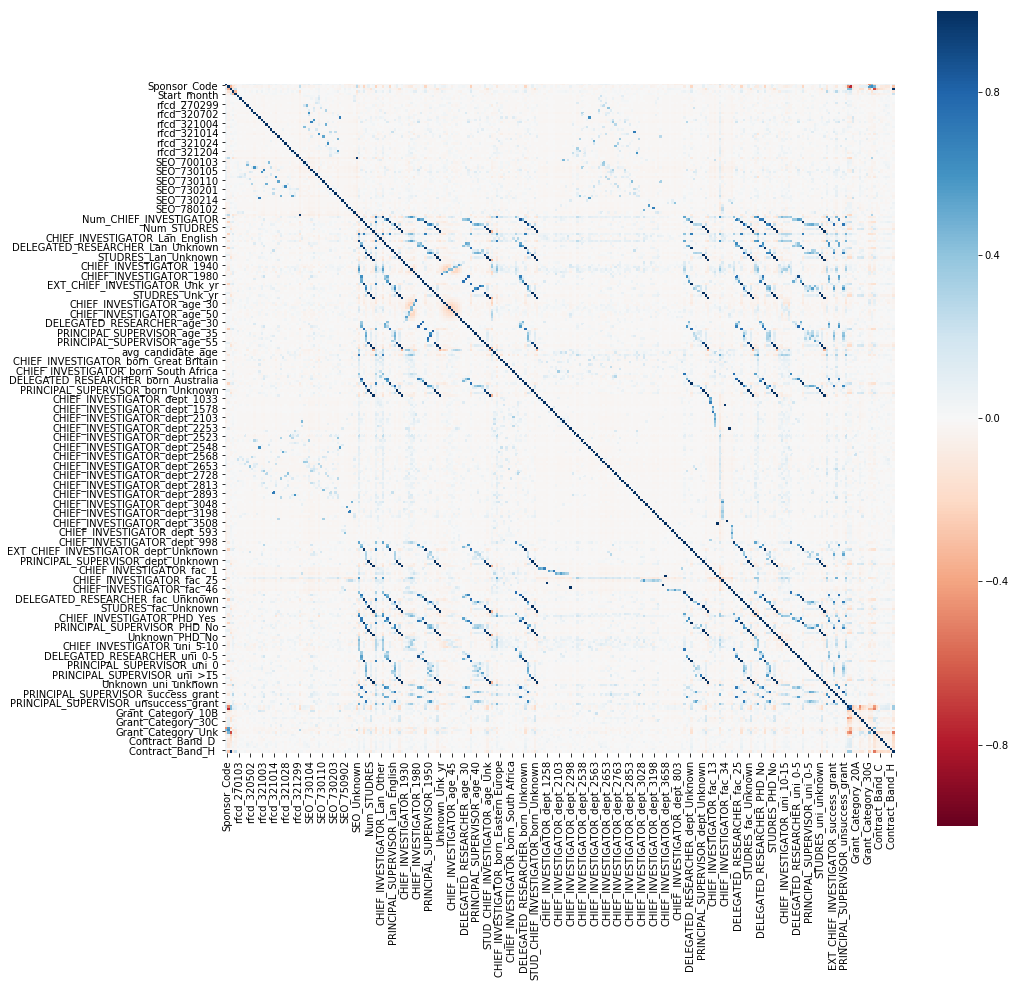

In [183]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, square=True, vmin=-1, vmax=1, cmap=plt.cm.RdBu, ax=ax)


In [184]:
high_corr = {}
for i, c1 in enumerate(corr.columns):
    for c2 in corr.columns[i+1:]:
        if (c2 not in high_corr) and abs(corr.loc[c1, c2] > .9):
            high_corr[c2] = (c1, corr.loc[c1, c2])

In [185]:
len(high_corr)

42

In [186]:
to_drop_highcorr = list(high_corr.keys())

In [187]:
X_train.drop(to_drop_highcorr, axis=1, inplace=True)
X_test.drop(to_drop_highcorr, axis=1, inplace=True)

In [188]:
X_train.shape, X_test.shape

((8708, 240), (2176, 240))

### Splitting Train/val

In [189]:
pre_2008 = (X_train['Start_year'] < 2008)
yr_2008 = (X_train['Start_year']==2008)

In [190]:
pre_2008.sum(), yr_2008.sum()

(6633, 2075)

In [191]:
X_2008 = X_train.loc[yr_2008]
y_2008 = y_train[yr_2008]
X_pre2008 = X_train.loc[pre_2008]
y_pre2008 = y_train[pre_2008]

X_2008.shape, y_2008.shape, X_pre2008.shape, y_pre2008.shape

((2075, 240), (2075,), (6633, 240), (6633,))

In [192]:
X_val, X_2008, y_val, y_2008 = train_test_split(X_2008, y_2008, test_size=.75, random_state=123)
X_val.shape, X_2008.shape, y_2008.shape, y_val.shape

((518, 240), (1557, 240), (1557,), (518,))

In [193]:
X_all = pd.concat([X_pre2008, X_2008], ignore_index=True)
y_all = pd.concat([y_pre2008, y_2008], ignore_index=True)

In [194]:
ts_fold = np.r_[-np.ones(len(X_pre2008)), np.zeros(len(X_2008)//2), np.ones(len(X_2008)-len(X_2008)//2)]

In [195]:
ps = PredefinedSplit(ts_fold)
ps

PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1]))

In [198]:
data = [X_2008, y_2008, X_pre2008, y_pre2008, X_all, y_all, X_val, y_val, ps]
pickle.dump(data, open('X2008_y2008_Xpre2008_ypre2008_Xall_yall_Xval_yval_cv.pkl', 'wb'))

In [199]:
pickle.dump(X_test, open('Xtest.pkl', 'wb'))

In [228]:
for tr_idx, ts_idx in ps.split(X=X_all):
    print(tr_idx.shape, ts_idx.shape)

(7412,) (778,)
(7411,) (779,)


### Logistic Regression

In [229]:
lr = LogisticRegression()
cross_val_score(LogisticRegression(penalty='l1'), X_all, y_all, cv=ps, scoring='roc_auc')

array([ 0.86989928,  0.87468391])

In [230]:
lr.fit(X_pre2008, y_pre2008)
roc_auc_score(y_2008, lr.predict(X_2008))

0.79280085008412271

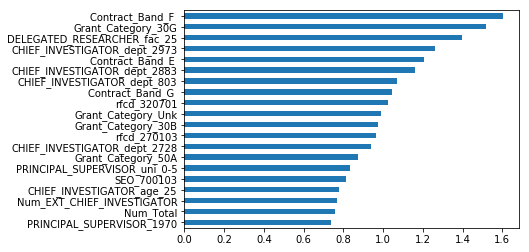

In [231]:
pd.Series(lr.coef_.ravel(), index=X_all.columns).abs().sort_values()[-20:].plot.barh()

### Linear Discriminant Analysis

In [232]:
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=None))
cross_val_score(lda, X_all, y_all, cv=ps, scoring='roc_auc')

array([ 0.88230216,  0.89035235])

In [233]:
lda.fit(X_pre2008, y_pre2008)
roc_auc_score(y_2008, lda.predict_proba(X_2008)[:, 1])

0.87158593819180019

In [234]:
params = {'lineardiscriminantanalysis__n_components': np.arange(1, 12)}
lda_grid = GridSearchCV(lda, params, cv=ps, scoring='roc_auc', verbose=1)

In [235]:
lda_grid.fit(X_all, y_all)

Fitting 2 folds for each of 11 candidates, totalling 22 fits


[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   10.5s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lineardiscriminantanalysis', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'lineardiscriminantanalysis__n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [236]:
X_all.shape, X_pre2008.shape, 

((8190, 240), (6633, 240))

In [237]:
lda_best = lda_grid.best_estimator_.fit(X_pre2008, y_pre2008)
lda_grid.best_params_, lda_grid.best_score_

({'lineardiscriminantanalysis__n_components': 1}, 0.88632983820772449)

In [238]:
roc_auc_score(y_2008, lda_best.predict_proba(X_2008)[:, 1])

0.87158593819180019

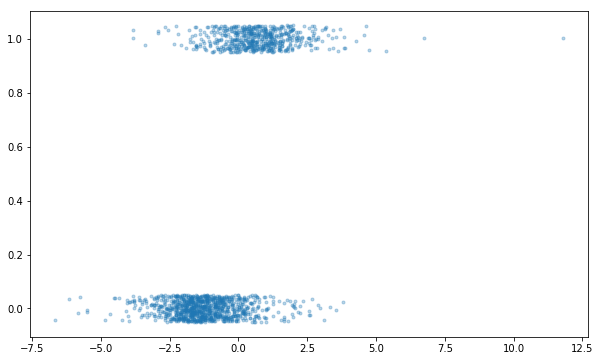

In [239]:
X_lda = lda_best.transform(X_2008)
plt.figure(figsize=(10, 6))
plt.plot(X_lda.ravel(), y_2008+np.random.uniform(-.05, .05, len(y_2008)), '.', alpha=.3)

In [240]:
pd.Series(lda_grid.best_estimator_.steps[1][1].coef_.ravel(), index=X_all.columns).abs().sort_values()[-10:]

Contract_Band_A                       0.685677
DELEGATED_RESEARCHER_PHD_No           0.719207
Grant_Category_30B                    0.846608
Num_DELEGATED_RESEARCHER              0.914833
Grant_Category_10A                    1.154405
CHIEF_INVESTIGATOR_success_grant      1.257763
DELEGATED_RESEARCHER_Lan_Unknown      1.263787
CHIEF_INVESTIGATOR_unsuccess_grant    1.280893
Num_EXT_CHIEF_INVESTIGATOR            1.922835
Num_Total                             3.058236
dtype: float64

In [241]:
def make_confusion_matrix(y_true, y_pred):
    return pd.DataFrame(confusion_matrix(y_true, y_pred), 
                     index=pd.Series(['-','+'], name='Predict'), 
                     columns=pd.Series(['-','+'], name='Actual'))

In [242]:
make_confusion_matrix(y_2008, lda_best.predict(X_2008))

Actual,-,+
Predict,,
-,855,127
+,167,408


### PLS

In [243]:
pls_reg = PLSRegression(n_components=4)
#pls_svd = PLSSVD()

In [244]:
pls_reg_grid = GridSearchCV(pls_reg, {'n_components':np.arange(1, 15)}, cv=ps, verbose=1)

In [245]:
pls_reg_grid.fit(X_all, y_all)

Fitting 2 folds for each of 14 candidates, totalling 28 fits


[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    6.0s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])),
       error_score='raise',
       estimator=PLSRegression(copy=True, max_iter=500, n_components=4, scale=True, tol=1e-06),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [246]:
pls_reg_grid.best_params_

{'n_components': 4}

In [248]:
class PLS_Transformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, n_components=None):
        self.n_components = n_components
        
    def fit(self, X, y):
        #print(X.shape, y.shape)
        self.pls_ = PLSRegression(n_components=self.n_components).fit(X, y)
        return self
    
    def transform(self, X):
        return self.pls_.transform(X)
    


In [249]:
pls_lda_pipe = make_pipeline(PLS_Transformer(n_components=4), LinearDiscriminantAnalysis())

In [250]:
cross_val_score(pls_lda_pipe, X_all, y_all, cv=ps, scoring='roc_auc', verbose=1)

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s finished


array([ 0.88871942,  0.8956194 ])

In [251]:
pls_lda_pipe.fit(X_pre2008, y_pre2008)

Pipeline(memory=None,
     steps=[('pls_transformer', PLS_Transformer(n_components=4)), ('lineardiscriminantanalysis', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001))])

In [252]:
roc_auc_score(y_2008, pls_lda_pipe.predict_proba(X_2008)[:, 1])

0.88201806428761187

In [253]:
make_confusion_matrix(y_2008, pls_lda_pipe.predict(X_2008))

Actual,-,+
Predict,,
-,851,131
+,154,421


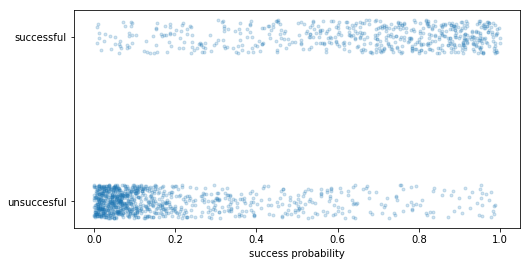

In [254]:
plt.figure(figsize=(8, 4))
plt.plot(pls_lda_pipe.predict_proba(X_2008)[:, 1], 
         y_2008+np.random.uniform(-.1, .1, len(y_2008)), '.', alpha=.2)
plt.xlabel('success probability')
plt.yticks([0, 1], ['unsuccesful', 'successful'])
plt.show()

### LogisticRegression with regularization

In [297]:
sgd = make_pipeline(StandardScaler(), SGDClassifier(loss='log', penalty='elasticnet'))

In [298]:
params = {'sgdclassifier__l1_ratio': np.linspace(0, 1, 11), 
          'sgdclassifier__alpha':np.exp2(np.arange(-5, 2))}

In [299]:
sgd_grid = GridSearchCV(sgd, params, cv=ps, scoring='roc_auc', verbose=1)

In [300]:
sgd_grid.fit(X_all, y_all)

Fitting 2 folds for each of 77 candidates, totalling 154 fits


[Parallel(n_jobs=1)]: Done 154 out of 154 | elapsed:   24.7s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('sgdclassifier', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'sgdclassifier__alpha': array([ 0.03125,  0.0625 ,  0.125  ,  0.25   ,  0.5    ,  1.     ,  2.     ]), 'sgdclassifier__l1_ratio': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [301]:
sgd_grid.best_params_, sgd_grid.best_score_

({'sgdclassifier__alpha': 0.0625,
  'sgdclassifier__l1_ratio': 0.20000000000000001},
 0.90224843293510792)

In [293]:
sgd_grid.best_params_, sgd_grid.best_score_

({'alpha': 0.25, 'l1_ratio': 0.60000000000000009}, 0.8432520036347193)

In [302]:
lr_reg_best = sgd_grid.best_estimator_

In [303]:
roc_auc_score(y_2008, lr_reg_best.predict_proba(X_2008)[:, 1])

0.90527760559638715

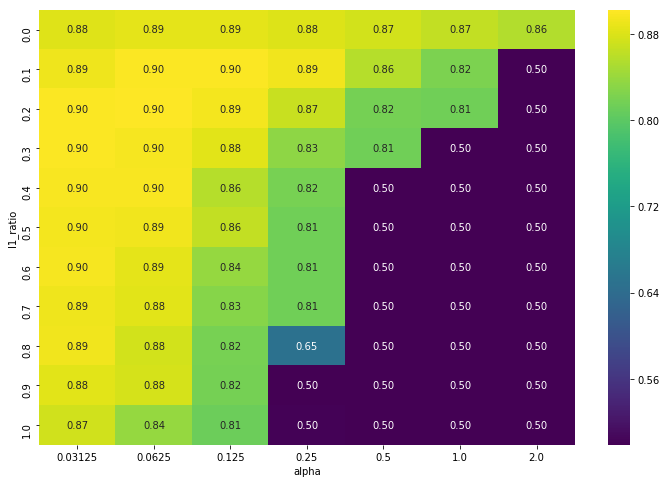

In [342]:
# heatmap : roc_auc by grid params
alphas = sgd_grid.cv_results_['param_sgdclassifier__alpha'].data.astype(float)
l1_ratios = sgd_grid.cv_results_['param_sgdclassifier__l1_ratio'].data.astype(float)
scores = sgd_grid.cv_results_['mean_test_score']


hm = pd.DataFrame(scores.reshape(7, 11), index=alphas[::11], columns=l1_ratios[:11])
hm.columns.name = 'l1_ratio'
hm.index.name = 'alpha'

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(hm.T, square=False, annot=True, fmt='.2f', xticklabels=True, yticklabels=True, ax=ax, cmap='viridis')

## Nearest Centroid

In [343]:
nc = make_pipeline(StandardScaler(), NearestCentroid())

In [344]:
nc_grid = GridSearchCV(nc, {'nearestcentroid__shrink_threshold':np.linspace(0, 1, 20)}, cv=ps)

In [345]:
nc_grid.fit(X_all, y_all)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  1,  1])),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('nearestcentroid', NearestCentroid(metric='euclidean', shrink_threshold=None))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'nearestcentroid__shrink_threshold': array([ 0.     ,  0.05263,  0.10526,  0.15789,  0.21053,  0.26316,
        0.31579,  0.36842,  0.42105,  0.47368,  0.52632,  0.57895,
        0.63158,  0.68421,  0.73684,  0.78947,  0.84211,  0.89474,
        0.94737,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [346]:
nc_grid.best_score_, nc_grid.best_params_

(0.7642903018625562,
 {'nearestcentroid__shrink_threshold': 0.84210526315789469})

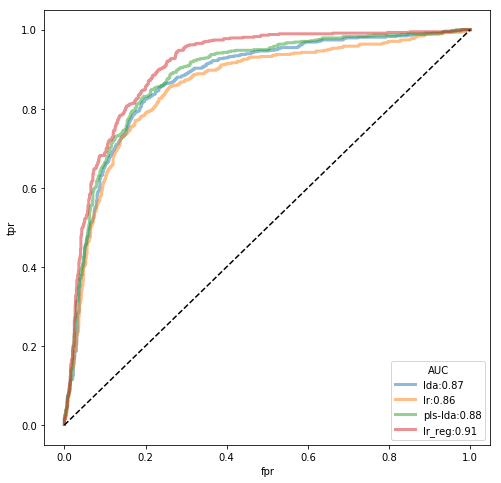

In [304]:
fpr_lda, tpr_lda, _ = roc_curve(y_2008, lda_best.predict_proba(X_2008)[:, 1])
fpr_lr, tpr_lr, _ = roc_curve(y_2008, lr.predict_proba(X_2008)[:, 1])
fpr_pls_lda, tpr_pls_lda, _ = roc_curve(y_2008, pls_lda_pipe.predict_proba(X_2008)[:, 1])
fpr_lr_reg, tpr_lr_reg, _ = roc_curve(y_2008, lr_reg_best.predict_proba(X_2008)[:, 1])

plt.figure(figsize=(8, 8))
plt.plot(fpr_lda, tpr_lda, alpha=.5, linewidth=3, 
         label='lda:{:.2f}'.format(roc_auc_score(y_2008, lda_best.predict_proba(X_2008)[:, 1])))
plt.plot(fpr_lr, tpr_lr, alpha=.5, linewidth=3,
         label='lr:{:.2f}'.format(roc_auc_score(y_2008, lr.predict_proba(X_2008)[:, 1])))
plt.plot(fpr_pls_lda, tpr_pls_lda, alpha=.5, linewidth=3,
         label='pls-lda:{:.2f}'.format(roc_auc_score(y_2008, pls_lda_pipe.predict_proba(X_2008)[:, 1])))
plt.plot(fpr_lr_reg, tpr_lr_reg, alpha=.5, linewidth=3,
         label='lr_reg:{:.2f}'.format(roc_auc_score(y_2008, lr_reg_best.predict_proba(X_2008)[:, 1])))


plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend(title='AUC')

In [285]:
X_val.shape, X_all.shape, X_2008.shape, X_pre2008.shape

((518, 240), (8190, 240), (1557, 240), (6633, 240))

In [ ]:
traintest.groupby(['CHIEF_INVESTIGATOR_success_grant', 'Grant_Status']).size().unstack().plot.bar()

In [ ]:
traintest.groupby(['CHIEF_INVESTIGATOR_unsuccess_grant', 'Grant_Status']).size().unstack().plot.bar()